# Confronto tra le config di MPC per Circuito Monza

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
import pandas as pd
import yaml
import numpy as np
import os
from PIL import Image
import glob
#%matplotlib inline

In [2]:
# Select map
MAP_NAME = "Monza_map"

In [3]:
csv_files = glob.glob(f'/home/weins/sim_ws/csv/*monza*', recursive=False)
for i, x in enumerate(csv_files):
    print(f"[{i}]: {x}")

[0]: /home/weins/sim_ws/csv/mpc_monza_safe_final_out.csv
[1]: /home/weins/sim_ws/csv/traj_race_monza_v2.csv
[2]: /home/weins/sim_ws/csv/monza_mpc_final_out.csv
[3]: /home/weins/sim_ws/csv/trajrace_pp_monza.csv
[4]: /home/weins/sim_ws/csv/mpc_monza_hp_final_out.csv
[5]: /home/weins/sim_ws/csv/monza_pp_final_out.csv
[6]: /home/weins/sim_ws/csv/mpc_monza_hp_controls_out.csv
[7]: /home/weins/sim_ws/csv/mpc_monza_fast_controls_out.csv
[8]: /home/weins/sim_ws/csv/pp_monza_controls_out.csv
[9]: /home/weins/sim_ws/csv/mpc_monza_fast_final_out.csv
[10]: /home/weins/sim_ws/csv/mpc_monza_safe_controls_out.csv
[11]: /home/weins/sim_ws/csv/pp_monza_final_out.csv
[12]: /home/weins/sim_ws/csv/traj_race_monza.csv


### MPC Configurazione High Performance

In [4]:
# Select file index
i = 4

In [5]:
raw_data = pd.read_csv(csv_files[i], sep=',')
raw_data

,x,y,theta,speed,accel,dist,energy,theta_map
0,2.817060,33.901425,0.008382,11.920551,-0.453402,0.009962,1.062821,3.054638
1,2.806676,33.784186,0.011424,12.006875,2.877472,0.041351,-5.979902,3.054567
2,2.785667,33.549511,0.014109,12.086161,2.642862,0.044726,-4.859111,3.054500
3,2.770315,33.401151,0.004883,12.131355,1.604961,0.043803,-2.770939,3.054437
4,2.764279,33.314509,0.014833,12.095999,0.327935,0.019527,-0.628205,3.054377
...,...,...,...,...,...,...,...,...
2863,2.896390,34.837282,-0.006353,11.817862,-0.063711,0.048190,0.122135,3.055048
2864,2.877006,34.603610,-0.003220,11.859018,1.371869,0.036509,-2.418713,3.054984
2865,2.867248,34.486712,-0.001143,11.909977,1.698632,0.005195,-2.671086,3.054919
2866,2.837469,34.135720,0.004754,11.934153,1.184774,0.056103,-1.755922,3.054782


### MPC HP

In [6]:
# Image resolution
size = 20 #40

# Select third dimention column index (color)
# [2] angle
# [3] velocity
# [4] acceleration
i = "dist"

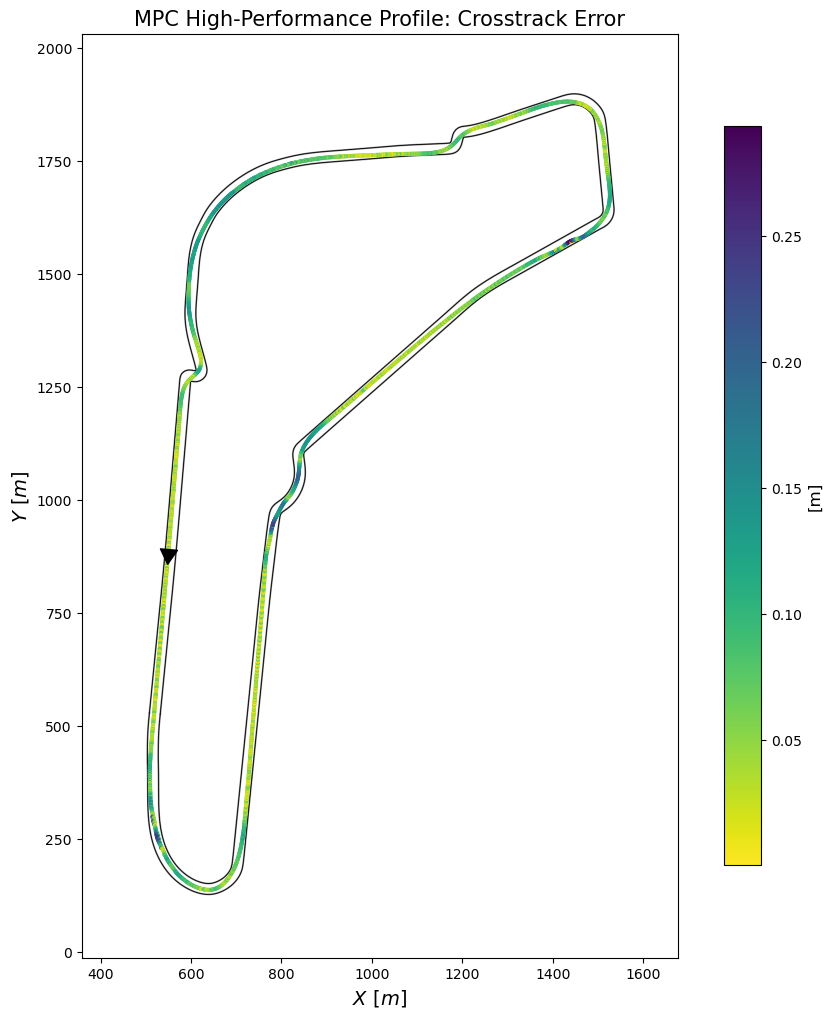

In [7]:
# Overlay the racetrack on the map
# load map yaml
if os.path.exists(f"/home/weins/sim_ws/src/f1tenth_gym_ros/maps/{MAP_NAME}.png"):
    map_img_path = f"/home/weins/sim_ws/src/f1tenth_gym_ros/maps/{MAP_NAME}.png"
else:
    raise Exception("Map not found!")

map_yaml_path = f"/home/weins/sim_ws/src/f1tenth_gym_ros/maps/{MAP_NAME}.yaml"
with open(map_yaml_path, 'r') as yaml_stream:
    try:
        map_metadata = yaml.safe_load(yaml_stream)
        map_resolution = map_metadata['resolution']
        origin = map_metadata['origin']
    except yaml.YAMLError as ex:
        print(ex)

# calculate map parameters
orig_x = origin[0]
orig_y = origin[1]
# ??? Should be 0>
orig_s = np.sin(origin[2])
orig_c = np.cos(origin[2])

# get the distance transform
transformed_data = raw_data.copy()
transformed_data -= np.array([orig_x, orig_y, 0, 0, 0, 0, 0, 0])
transformed_data.iloc[:, :2] /= map_resolution

raw_map_img = np.array(Image.open(map_img_path).transpose(Image.FLIP_TOP_BOTTOM))
raw_map_img = raw_map_img.astype(np.float64)

# Normalize the color values
norm = mcolors.Normalize(vmin=transformed_data.loc[:, i].min(), vmax=transformed_data.loc[:, i].max())

%matplotlib inline
plt.figure(figsize=(12, 12))
plt.title("MPC High-Performance Profile: Crosstrack Error", fontsize=15)
plt.scatter(transformed_data.iloc[:, 0], transformed_data.iloc[:, 1], c=transformed_data.loc[:, i], marker=".", s=15, cmap='viridis_r', norm=norm)

cbar = plt.colorbar(shrink=0.8)
plt.scatter(transformed_data.loc[0, 'x'], transformed_data.loc[0, 'y'], c='black', marker=(3,0,transformed_data.loc[0, 'theta_map']*180/3.1415), s=200)
# TODO: change label 
cbar.set_label('[m]', fontsize=12) #, labelpad=-60)

plt.imshow(raw_map_img, cmap='gray', origin='lower')
plt.xlabel('$X \ [m]$', fontsize=14)  # Add x-axis label
plt.ylabel('$Y \ [m]$', fontsize=14)  # Add y-axis label
plt.xticks(fontsize=10)  # Increase x-axis tick font size
plt.yticks(fontsize=10)  # Increase y-axis tick font size

# Set axis limits to reduce white space
plt.xlim(transformed_data.iloc[:, 0].min() - 150, transformed_data.iloc[:, 0].max() + 150)
plt.ylim(transformed_data.iloc[:, 1].min() - 150, transformed_data.iloc[:, 1].max() + 150)

# Save the figure as an image file
plt.savefig('MPC Profiles Comparisons/MPC High-Performance Crosstrack Error Monza Baseline.png', dpi=300, bbox_inches='tight')

#plt.axis('off')
plt.show()

## Visualize in 3D

### MPC HP

In [8]:
# Change third dimention (before color now z-axis)
i = 4

# Change fourth dimention (color)
# [2] angle
# [3] velocity
# [4] acceleration
j = 5

In [9]:
raw_data_np = transformed_data.to_numpy()

from mpl_toolkits.mplot3d import Axes3D
%matplotlib qt
# Visualize Velocity Profile
scale_x = 1.0
scale_y = 1.0
scale_z = 0.3  # scale z axis such that it does not appear stretched

# create 3d plot
fig = plt.figure(figsize=(size, size))
ax = fig.gca(projection='3d')

# recast get_proj function to use scaling factors for the axes
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([scale_x, scale_y, scale_z, 1.0]))

ax.grid()
ax.set_aspect("auto")
ax.set_xlabel("east in m")
ax.set_ylabel("north in m")

# Doesn't work
# import matplotlib
# x,y = np.mgrid[0:orig_map_img.shape[0], 0:orig_map_img.shape[1]]
# ax.plot_surface(x,y,np.sin(0*x), facecolors=matplotlib.cm.ScalarMappable(cmap='gray').to_rgba(orig_map_img))

# plot velocity profile in 3D
ax.plot(raw_data_np[:, 0], raw_data_np[:, 1], raw_data_np[:, i], color="k")
# TODO: change label
ax.set_zlabel("Acceleration [$m/s^2$]")

# plot vertical lines visualizing acceleration and deceleration zones
ind_stepsize = 1
cur_ind = 0
no_points_traj_vdc = np.shape(raw_data_np)[0]
prev_vel = 0
curr_vel = 0

import matplotlib
cmap = matplotlib.cm.viridis_r
norm3d = matplotlib.colors.Normalize(vmin=raw_data_np[:, j].min(), vmax=raw_data_np[:, j].max())


while cur_ind < no_points_traj_vdc - 1:
	curr_vel = raw_data_np[cur_ind, i]
	x_tmp = [raw_data_np[cur_ind, 0], raw_data_np[cur_ind, 0]]
	y_tmp = [raw_data_np[cur_ind, 1], raw_data_np[cur_ind, 1]]
	z_tmp = [0.0, curr_vel]  # plot line with height depending on velocity

	# get proper color for line depending on acceleration

	# plot line
	ax.plot(x_tmp, y_tmp, z_tmp, color=cmap(norm3d(raw_data_np[cur_ind, j])) )

	# increment index
	cur_ind += ind_stepsize


plt.show()

/tmp/ipykernel_17837/811122224.py:12: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


# MPC Fast Performance

## Spa

In [10]:
csv_files = glob.glob(f'/home/weins/sim_ws/csv/*monza*', recursive=False)
for i, x in enumerate(csv_files):
    print(f"[{i}]: {x}")

[0]: /home/weins/sim_ws/csv/mpc_monza_safe_final_out.csv
[1]: /home/weins/sim_ws/csv/traj_race_monza_v2.csv
[2]: /home/weins/sim_ws/csv/monza_mpc_final_out.csv
[3]: /home/weins/sim_ws/csv/trajrace_pp_monza.csv
[4]: /home/weins/sim_ws/csv/mpc_monza_hp_final_out.csv
[5]: /home/weins/sim_ws/csv/monza_pp_final_out.csv
[6]: /home/weins/sim_ws/csv/mpc_monza_hp_controls_out.csv
[7]: /home/weins/sim_ws/csv/mpc_monza_fast_controls_out.csv
[8]: /home/weins/sim_ws/csv/pp_monza_controls_out.csv
[9]: /home/weins/sim_ws/csv/mpc_monza_fast_final_out.csv
[10]: /home/weins/sim_ws/csv/mpc_monza_safe_controls_out.csv
[11]: /home/weins/sim_ws/csv/pp_monza_final_out.csv
[12]: /home/weins/sim_ws/csv/traj_race_monza.csv


In [11]:
# Select file index
i = 9

MPC Configurazione Fast

In [12]:
raw_data = pd.read_csv(csv_files[i], sep=',')
raw_data

,x,y,theta,speed,accel,dist,energy,theta_map
0,2.816212,33.846572,0.016819,12.246661,3.000000,0.046542,-3.373353,3.054638
1,2.805060,33.727260,0.016729,12.313973,2.243720,0.017457,-2.085839,3.054567
2,2.788222,33.540381,0.011977,12.336134,1.328450,0.053910,-1.200494,3.054500
3,2.782438,33.488336,0.015367,12.330680,0.556891,0.044512,-0.546315,3.054437
4,2.770989,33.368696,0.014304,12.354756,0.802538,0.074038,-0.760720,3.054377
...,...,...,...,...,...,...,...,...
2846,2.901183,34.798800,0.004524,12.062506,-0.793638,0.014630,0.795253,3.055048
2847,2.870294,34.442145,0.011157,12.127437,1.485281,0.048966,-1.127613,3.054919
2848,2.868306,34.374482,0.016638,12.105566,0.929014,0.037494,-0.781293,3.054851
2849,2.849009,34.204104,0.013933,12.123853,-0.119476,0.016547,0.092307,3.054782


In [13]:
# Image resolution
size = 20 #40

# Select third dimention column index (color)
# [2] angle
# [3] velocity
# [4] acceleration
i = "dist"

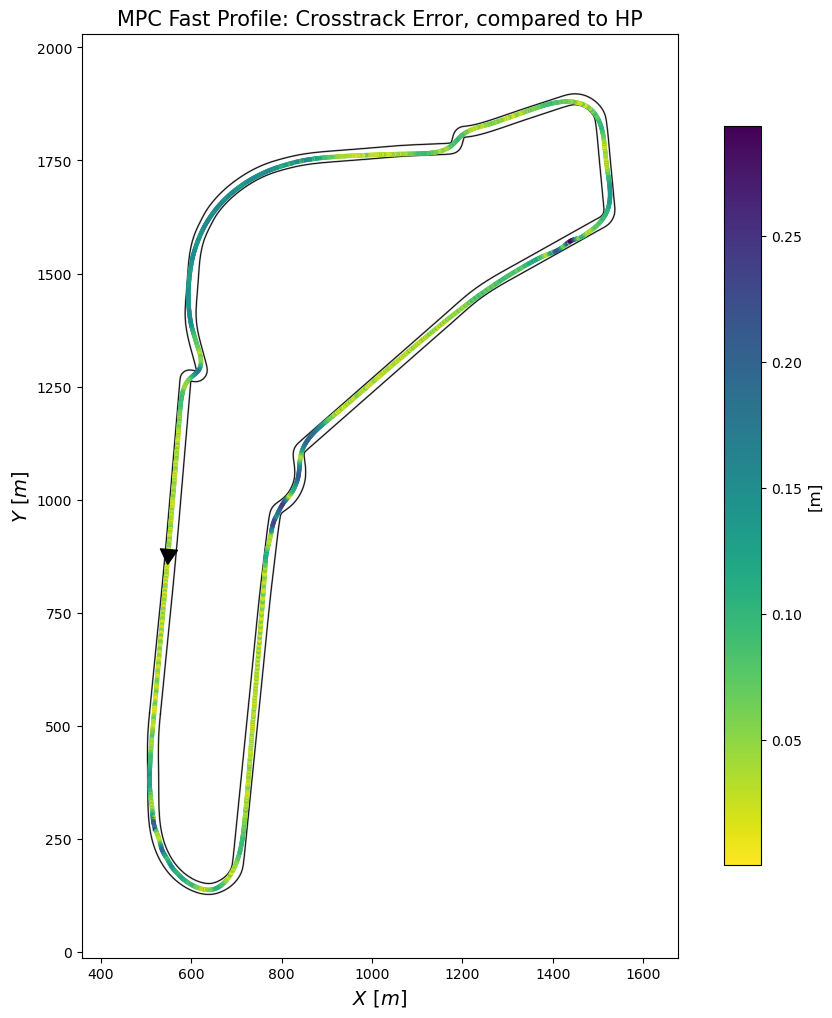

In [14]:
# Overlay the racetrack on the map
# load map yaml
if os.path.exists(f"/home/weins/sim_ws/src/f1tenth_gym_ros/maps/{MAP_NAME}.png"):
    map_img_path = f"/home/weins/sim_ws/src/f1tenth_gym_ros/maps/{MAP_NAME}.png"
else:
    raise Exception("Map not found!")

map_yaml_path = f"/home/weins/sim_ws/src/f1tenth_gym_ros/maps/{MAP_NAME}.yaml"
with open(map_yaml_path, 'r') as yaml_stream:
    try:
        map_metadata = yaml.safe_load(yaml_stream)
        map_resolution = map_metadata['resolution']
        origin = map_metadata['origin']
    except yaml.YAMLError as ex:
        print(ex)

# calculate map parameters
orig_x = origin[0]
orig_y = origin[1]
# ??? Should be 0>
orig_s = np.sin(origin[2])
orig_c = np.cos(origin[2])

# get the distance transform
transformed_data = raw_data.copy()
transformed_data -= np.array([orig_x, orig_y, 0, 0, 0, 0, 0, 0])
transformed_data.iloc[:, :2] /= map_resolution

raw_map_img = np.array(Image.open(map_img_path).transpose(Image.FLIP_TOP_BOTTOM))
raw_map_img = raw_map_img.astype(np.float64)

%matplotlib inline
plt.figure(figsize=(12, 12))
plt.title("MPC Fast Profile: Crosstrack Error, compared to HP", fontsize=15)
plt.scatter(transformed_data.iloc[:, 0], transformed_data.iloc[:, 1], c=transformed_data.loc[:, i], marker=".", s=20, cmap='viridis_r', norm=norm)

cbar = plt.colorbar(shrink=0.8)
plt.scatter(transformed_data.loc[0, 'x'], transformed_data.loc[0, 'y'], c='black', marker=(3,0,transformed_data.loc[0, 'theta_map']*180/3.1415), s=200)
# TODO: change label 
cbar.set_label('[m]', fontsize=12) #, labelpad=-60)

plt.imshow(raw_map_img, cmap='gray', origin='lower')
plt.xlabel('$X \ [m]$', fontsize=14)  # Add x-axis label
plt.ylabel('$Y \ [m]$', fontsize=14)  # Add y-axis label
plt.xticks(fontsize=10)  # Increase x-axis tick font size
plt.yticks(fontsize=10)  # Increase y-axis tick font size

# Set axis limits to reduce white space
plt.xlim(transformed_data.iloc[:, 0].min() - 150, transformed_data.iloc[:, 0].max() + 150)
plt.ylim(transformed_data.iloc[:, 1].min() - 150, transformed_data.iloc[:, 1].max() + 150)

# Save the figure as an image file
plt.savefig('MPC Profiles Comparisons/MPC Fast Crosstrack Error Monza vs HP.png', dpi=300, bbox_inches='tight')

#plt.axis('off')
plt.show()

## Visualize in 3D

### MPC Fast Profile

In [15]:
# Change third dimention (before color now z-axis)
i = 4

# Change fourth dimention (color)
# [2] angle
# [3] velocity
# [4] acceleration
j = 5

In [16]:
raw_data_np = transformed_data.to_numpy()

from mpl_toolkits.mplot3d import Axes3D
%matplotlib qt
# Visualize Velocity Profile
scale_x = 1.0
scale_y = 1.0
scale_z = 0.3  # scale z axis such that it does not appear stretched

# create 3d plot
fig = plt.figure(figsize=(size, size))
ax = fig.gca(projection='3d')

# recast get_proj function to use scaling factors for the axes
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([scale_x, scale_y, scale_z, 1.0]))

ax.grid()
ax.set_aspect("auto")
ax.set_xlabel("east in m")
ax.set_ylabel("north in m")

# Doesn't work
# import matplotlib
# x,y = np.mgrid[0:orig_map_img.shape[0], 0:orig_map_img.shape[1]]
# ax.plot_surface(x,y,np.sin(0*x), facecolors=matplotlib.cm.ScalarMappable(cmap='gray').to_rgba(orig_map_img))

# plot velocity profile in 3D
ax.plot(raw_data_np[:, 0], raw_data_np[:, 1], raw_data_np[:, i], color="k")
# TODO: change label
ax.set_zlabel("Acceleration [$m/s^2$]")

# plot vertical lines visualizing acceleration and deceleration zones
ind_stepsize = 1
cur_ind = 0
no_points_traj_vdc = np.shape(raw_data_np)[0]
prev_vel = 0
curr_vel = 0

import matplotlib
cmap = matplotlib.cm.viridis_r
norm3d = matplotlib.colors.Normalize(vmin=raw_data_np[:, j].min(), vmax=raw_data_np[:, j].max())


while cur_ind < no_points_traj_vdc - 1:
	curr_vel = raw_data_np[cur_ind, i]
	x_tmp = [raw_data_np[cur_ind, 0], raw_data_np[cur_ind, 0]]
	y_tmp = [raw_data_np[cur_ind, 1], raw_data_np[cur_ind, 1]]
	z_tmp = [0.0, curr_vel]  # plot line with height depending on velocity

	# get proper color for line depending on acceleration

	# plot line
	ax.plot(x_tmp, y_tmp, z_tmp, color=cmap(norm3d(raw_data_np[cur_ind, j])) )

	# increment index
	cur_ind += ind_stepsize


plt.show()

/tmp/ipykernel_17837/811122224.py:12: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


# MPC Safe Performance

## Spa

In [17]:
csv_files = glob.glob(f'/home/weins/sim_ws/csv/*monza*', recursive=False)
for i, x in enumerate(csv_files):
    print(f"[{i}]: {x}")

[0]: /home/weins/sim_ws/csv/mpc_monza_safe_final_out.csv
[1]: /home/weins/sim_ws/csv/traj_race_monza_v2.csv
[2]: /home/weins/sim_ws/csv/monza_mpc_final_out.csv
[3]: /home/weins/sim_ws/csv/trajrace_pp_monza.csv
[4]: /home/weins/sim_ws/csv/mpc_monza_hp_final_out.csv
[5]: /home/weins/sim_ws/csv/monza_pp_final_out.csv
[6]: /home/weins/sim_ws/csv/mpc_monza_hp_controls_out.csv
[7]: /home/weins/sim_ws/csv/mpc_monza_fast_controls_out.csv
[8]: /home/weins/sim_ws/csv/pp_monza_controls_out.csv
[9]: /home/weins/sim_ws/csv/mpc_monza_fast_final_out.csv
[10]: /home/weins/sim_ws/csv/mpc_monza_safe_controls_out.csv
[11]: /home/weins/sim_ws/csv/pp_monza_final_out.csv
[12]: /home/weins/sim_ws/csv/traj_race_monza.csv


In [18]:
# Select file index
i = 0

MPC Configurazione Safe

In [19]:
raw_data = pd.read_csv(csv_files[i], sep=',')
raw_data

,x,y,theta,speed,accel,dist,energy,theta_map
0,2.803333,33.850772,-0.009248,11.143289,10.0,0.043000,-52.510658,3.054638
1,2.796140,33.733537,-0.012098,11.154585,10.0,0.010406,-52.657457,3.054567
2,2.775202,33.526079,-0.013250,11.183520,10.0,0.068981,-52.144570,3.054500
3,2.765950,33.417569,-0.013698,11.197168,10.0,0.028156,-52.203410,3.054437
4,2.753778,33.229834,-0.000994,1.628395,10.0,0.065955,-410.644819,3.054377
...,...,...,...,...,...,...,...,...
2904,2.892012,34.817274,0.008377,11.024360,10.0,0.027820,-48.847021,3.055048
2905,2.871941,34.603457,0.005183,11.051004,10.0,0.036995,-47.850500,3.054984
2906,2.861945,34.496347,0.003244,11.064003,10.0,0.005986,-47.364373,3.054919
2907,2.842081,34.281715,-0.000432,11.090647,10.0,0.060200,-46.367852,3.054851


In [20]:
# Image resolution
size = 20 #40

# Select third dimention column index (color)
# [2] angle
# [3] velocity
# [4] acceleration
i = "dist"

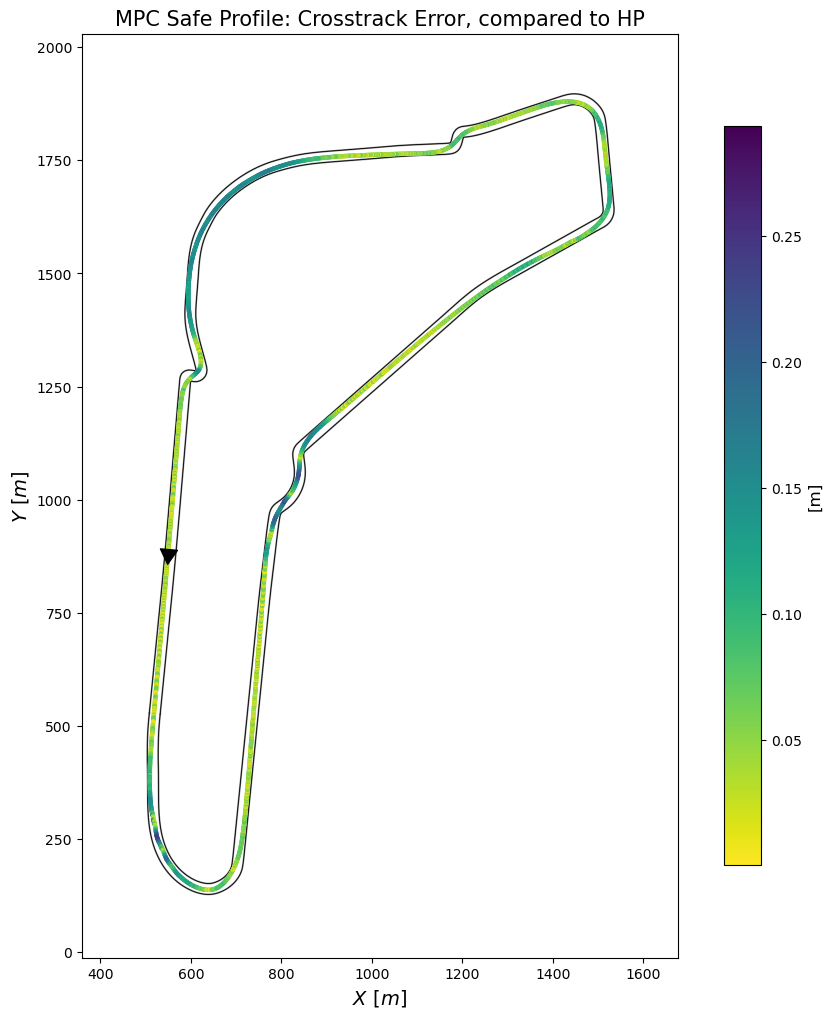

In [21]:
# Overlay the racetrack on the map
# load map yaml
if os.path.exists(f"/home/weins/sim_ws/src/f1tenth_gym_ros/maps/{MAP_NAME}.png"):
    map_img_path = f"/home/weins/sim_ws/src/f1tenth_gym_ros/maps/{MAP_NAME}.png"
else:
    raise Exception("Map not found!")

map_yaml_path = f"/home/weins/sim_ws/src/f1tenth_gym_ros/maps/{MAP_NAME}.yaml"
with open(map_yaml_path, 'r') as yaml_stream:
    try:
        map_metadata = yaml.safe_load(yaml_stream)
        map_resolution = map_metadata['resolution']
        origin = map_metadata['origin']
    except yaml.YAMLError as ex:
        print(ex)

# calculate map parameters
orig_x = origin[0]
orig_y = origin[1]
# ??? Should be 0>
orig_s = np.sin(origin[2])
orig_c = np.cos(origin[2])

# get the distance transform
transformed_data = raw_data.copy()
transformed_data -= np.array([orig_x, orig_y, 0, 0, 0, 0, 0, 0])
transformed_data.iloc[:, :2] /= map_resolution

raw_map_img = np.array(Image.open(map_img_path).transpose(Image.FLIP_TOP_BOTTOM))
raw_map_img = raw_map_img.astype(np.float64)

%matplotlib inline
plt.figure(figsize=(12, 12))
plt.title("MPC Safe Profile: Crosstrack Error, compared to HP", fontsize=15)
plt.scatter(transformed_data.iloc[:, 0], transformed_data.iloc[:, 1], c=transformed_data.loc[:, i], marker=".", s=20, cmap='viridis_r', norm=norm)

cbar = plt.colorbar(shrink=0.8)
plt.scatter(transformed_data.loc[0, 'x'], transformed_data.loc[0, 'y'], c='black', marker=(3,0,transformed_data.loc[0, 'theta_map']*180/3.1415), s=200)
# TODO: change label 
cbar.set_label('[m]', fontsize=12) #, labelpad=-60)

plt.imshow(raw_map_img, cmap='gray', origin='lower')
plt.xlabel('$X \ [m]$', fontsize=14)  # Add x-axis label
plt.ylabel('$Y \ [m]$', fontsize=14)  # Add y-axis label
plt.xticks(fontsize=10)  # Increase x-axis tick font size
plt.yticks(fontsize=10)  # Increase y-axis tick font size

# Set axis limits to reduce white space
plt.xlim(transformed_data.iloc[:, 0].min() - 150, transformed_data.iloc[:, 0].max() + 150)
plt.ylim(transformed_data.iloc[:, 1].min() - 150, transformed_data.iloc[:, 1].max() + 150)

# Save the figure as an image file
plt.savefig('MPC Profiles Comparisons/MPC Safe Crosstrack Error Monza vs HP.png', dpi=300, bbox_inches='tight')

#plt.axis('off')
plt.show()

## Visualize in 3D

### MPC Safe Profile

In [22]:
# Change third dimention (before color now z-axis)
i = 4

# Change fourth dimention (color)
# [2] angle
# [3] velocity
# [4] acceleration
j = 5

In [23]:
raw_data_np = transformed_data.to_numpy()

from mpl_toolkits.mplot3d import Axes3D
%matplotlib qt
# Visualize Velocity Profile
scale_x = 1.0
scale_y = 1.0
scale_z = 0.3  # scale z axis such that it does not appear stretched

# create 3d plot
fig = plt.figure(figsize=(size, size))
ax = fig.gca(projection='3d')

# recast get_proj function to use scaling factors for the axes
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([scale_x, scale_y, scale_z, 1.0]))

ax.grid()
ax.set_aspect("auto")
ax.set_xlabel("east in m")
ax.set_ylabel("north in m")

# Doesn't work
# import matplotlib
# x,y = np.mgrid[0:orig_map_img.shape[0], 0:orig_map_img.shape[1]]
# ax.plot_surface(x,y,np.sin(0*x), facecolors=matplotlib.cm.ScalarMappable(cmap='gray').to_rgba(orig_map_img))

# plot velocity profile in 3D
ax.plot(raw_data_np[:, 0], raw_data_np[:, 1], raw_data_np[:, i], color="k")
# TODO: change label
ax.set_zlabel("Acceleration [$m/s^2$]")

# plot vertical lines visualizing acceleration and deceleration zones
ind_stepsize = 1
cur_ind = 0
no_points_traj_vdc = np.shape(raw_data_np)[0]
prev_vel = 0
curr_vel = 0

import matplotlib
cmap = matplotlib.cm.viridis_r
norm3d = matplotlib.colors.Normalize(vmin=raw_data_np[:, j].min(), vmax=raw_data_np[:, j].max())


while cur_ind < no_points_traj_vdc - 1:
	curr_vel = raw_data_np[cur_ind, i]
	x_tmp = [raw_data_np[cur_ind, 0], raw_data_np[cur_ind, 0]]
	y_tmp = [raw_data_np[cur_ind, 1], raw_data_np[cur_ind, 1]]
	z_tmp = [0.0, curr_vel]  # plot line with height depending on velocity

	# get proper color for line depending on acceleration

	# plot line
	ax.plot(x_tmp, y_tmp, z_tmp, color=cmap(norm3d(raw_data_np[cur_ind, j])) )

	# increment index
	cur_ind += ind_stepsize


plt.show()

/tmp/ipykernel_17837/811122224.py:12: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')
